In [8]:
# test ID == 0
import os
import pandas as pd
import numpy as np

# === 1. Define column names and input folder paths ===
column_names = ['X', 'Y', 'Z', 'Pressure', 'GripAngle', 'Timestamp', 'TestID']
parkinsonians_folder = r'C:\Users\adklt\OneDrive - aegean.gr\FinalPapers\PhDTestFolder\hw_dataset\hw_dataset\parkinson'
healthy_controls_folder = r'C:\Users\adklt\OneDrive - aegean.gr\FinalPapers\PhDTestFolder\hw_dataset\hw_dataset\control'

# === 2. Load and filter files for TestID == 0 ===
def load_and_combine_files(folder_path):
    combined_df = pd.DataFrame()
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.txt'):
            file_path = os.path.join(folder_path, file_name)
            df = pd.read_csv(file_path, delimiter=';', header=None, names=column_names)
            df = df[df['TestID'] == 0]
            if not df.empty:
                df['PatientID'] = file_name
                combined_df = pd.concat([combined_df, df], ignore_index=True)
    return combined_df

# === 3. Segment data and compute features ===
def compute_features(data):
    segments = []
    current_segment = []
    for _, row in data.iterrows():
        if row['Pressure'] > 0:
            current_segment.append(row)
        elif current_segment:
            segments.append(pd.DataFrame(current_segment))
            current_segment = []
    if current_segment:
        segments.append(pd.DataFrame(current_segment))

    features = []
    for segment in segments:
        if len(segment) <= 1:
            continue
        x_diff = np.diff(segment['X'])
        y_diff = np.diff(segment['Y'])
        di = np.sum(np.sqrt(x_diff**2 + y_diff**2))
        Ti = len(segment) / 133  # 133 Hz sampling
        si = di / Ti if Ti > 0 else 0
        avg_pressure = segment['Pressure'].mean()

        features.append({
            'SegmentLength': di,
            'SegmentTime': Ti,
            'Speed': si,
            'AveragePressure': avg_pressure
        })

    if features:
        features_df = pd.DataFrame(features)
        return {
            'SegmentLength': features_df['SegmentLength'].mean(),
            'SegmentTime': features_df['SegmentTime'].mean(),
            'Speed': features_df['Speed'].mean(),
            'AveragePressure': features_df['AveragePressure'].mean()
        }
    else:
        return {
            'SegmentLength': 0,
            'SegmentTime': 0,
            'Speed': 0,
            'AveragePressure': 0
        }

# === 4. Compute descriptive statistics ===
def compute_detailed_statistics(stats_list):
    stats_df = pd.DataFrame(stats_list)
    detailed_stats = stats_df.describe(percentiles=[0.25, 0.5, 0.75]).T
    detailed_stats['std'] = stats_df.std(numeric_only=True)
    return detailed_stats

# === 5. Load raw data ===
parkinsonians = load_and_combine_files(parkinsonians_folder)
healthy_controls = load_and_combine_files(healthy_controls_folder)

# === 6. Compute features and tag each row with PatientID ===
parkinsonian_stats = []
for patient_id in parkinsonians['PatientID'].unique():
    patient_data = parkinsonians[parkinsonians['PatientID'] == patient_id]
    features = compute_features(patient_data)
    features['PatientID'] = patient_id
    parkinsonian_stats.append(features)

healthy_stats = []
for patient_id in healthy_controls['PatientID'].unique():
    patient_data = healthy_controls[healthy_controls['PatientID'] == patient_id]
    features = compute_features(patient_data)
    features['PatientID'] = patient_id
    healthy_stats.append(features)

# === 7. Save real per-patient data ===
parkinsonian_df = pd.DataFrame(parkinsonian_stats)
parkinsonian_df['Group'] = 'Parkinsonian'
parkinsonian_df.to_csv('parkinsonian_real_data20250511.csv', index=False)

healthy_df = pd.DataFrame(healthy_stats)
healthy_df['Group'] = 'Healthy'
healthy_df.to_csv('healthy_real_data20250511.csv', index=False)

# === 8. Save statistical summaries ===
parkinsonian_detailed_stats = compute_detailed_statistics(parkinsonian_stats)
healthy_detailed_stats = compute_detailed_statistics(healthy_stats)

parkinsonian_detailed_stats.to_csv('parkinsonian_detailed_statistics20250511.csv', index=True)
healthy_detailed_stats.to_csv('healthy_detailed_statistics20250511.csv', index=True)

# === 9. Output ===
print("✅ Detailed per-patient data saved:")
print(" - parkinsonian_real_data20250511.csv")
print(" - healthy_real_data20250511.csv")

print("\n📊 Summary statistics saved:")
print(" - parkinsonian_detailed_statistics20250511.csv")
print(" - healthy_detailed_statistics20250511.csv")


✅ Detailed per-patient data saved:
 - parkinsonian_real_data20250511.csv
 - healthy_real_data20250511.csv

📊 Summary statistics saved:
 - parkinsonian_detailed_statistics20250511.csv
 - healthy_detailed_statistics20250511.csv



🚀 Training GAN for Parkinsonian...
🔄 Generating 1000 valid synthetic samples for Parkinsonian...
✅ Synthetic data saved for Parkinsonian.


🔍 Validation for Parkinsonian samples:
📌 SegmentLength
  Wasserstein Distance: 43.68
  T-test: t-stat = -0.22, p = 0.8289

📌 SegmentTime
  Wasserstein Distance: 2.02
  T-test: t-stat = -0.49, p = 0.6255

📌 Speed
  Wasserstein Distance: 11.37
  T-test: t-stat = 0.47, p = 0.6417

📌 AveragePressure
  Wasserstein Distance: 28.51
  T-test: t-stat = 0.22, p = 0.8253



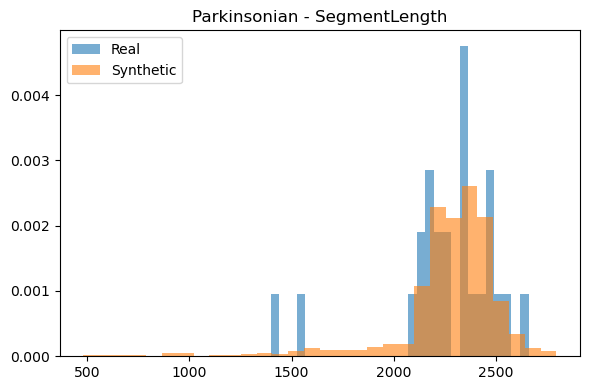

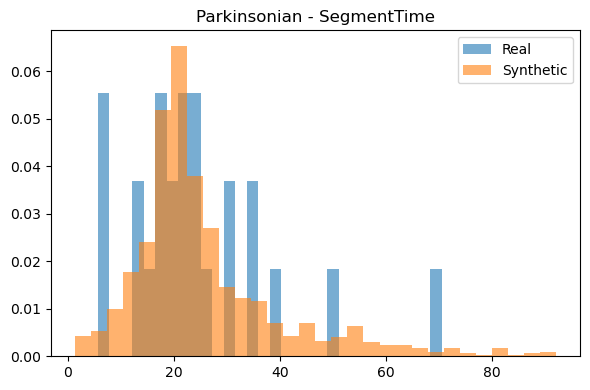

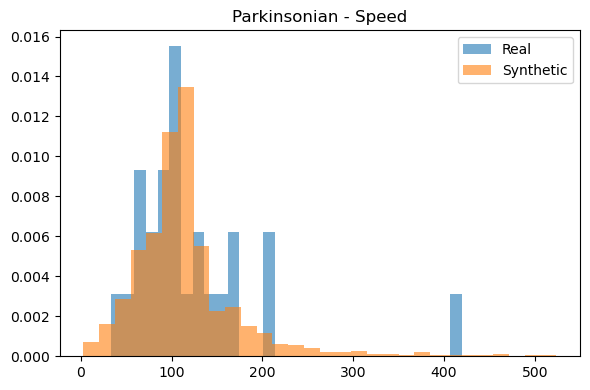

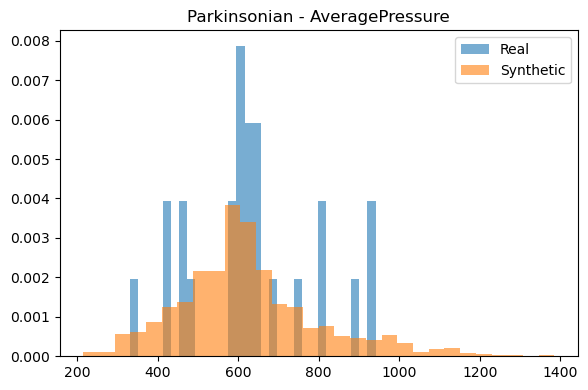


🚀 Training GAN for Healthy...
🔄 Generating 1000 valid synthetic samples for Healthy...
✅ Synthetic data saved for Healthy.


🔍 Validation for Healthy samples:
📌 SegmentLength
  Wasserstein Distance: 20.81
  T-test: t-stat = 0.16, p = 0.8736

📌 SegmentTime
  Wasserstein Distance: 1.58
  T-test: t-stat = 0.18, p = 0.8614

📌 Speed
  Wasserstein Distance: 5.93
  T-test: t-stat = 0.04, p = 0.9662

📌 AveragePressure
  Wasserstein Distance: 12.34
  T-test: t-stat = -0.11, p = 0.9165



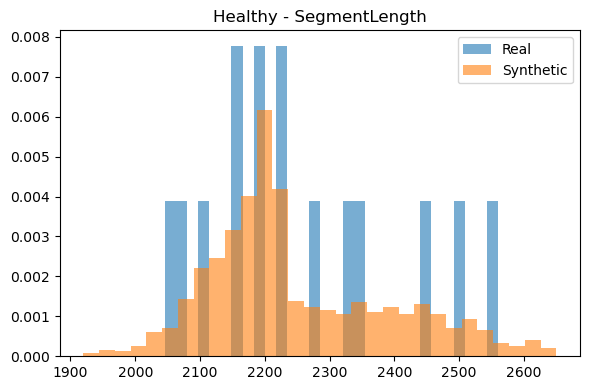

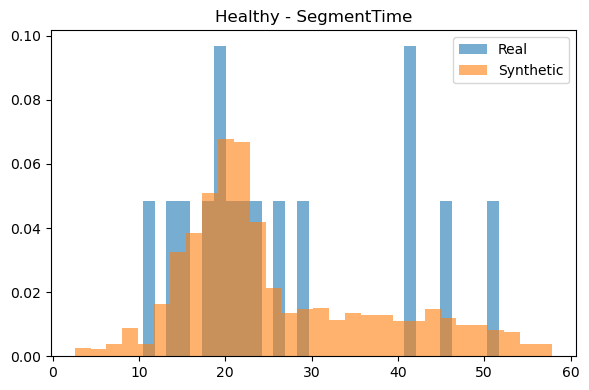

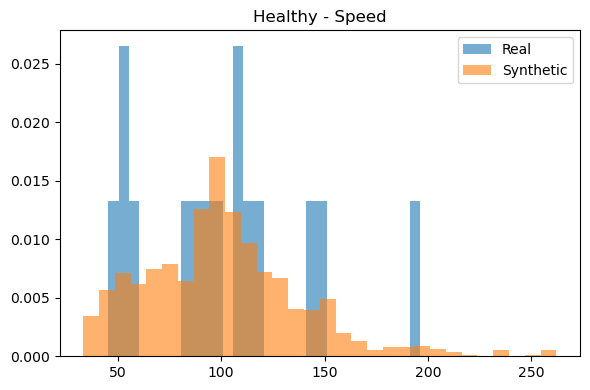

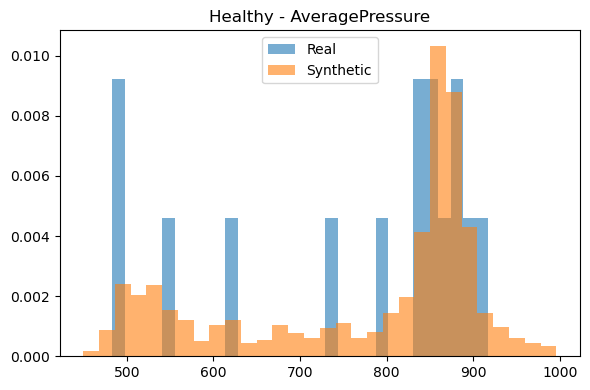

In [40]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.stats import wasserstein_distance, ttest_ind

# ========== CONFIG ==========
latent_dim = 10
features = 4
n_samples = 1000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_gen_size = 64  # how many samples to generate per loop during filtering

# ========== MODEL DEFINITIONS ==========

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, features)
        )

    def forward(self, z):
        return self.model(z)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(features, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 32),
            nn.LeakyReLU(0.2),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# ========== GAN TRAINING FUNCTION ==========

def train_gan(real_data, n_epochs=4000, batch_size=64):
    G = Generator().to(device)
    D = Discriminator().to(device)

    criterion = nn.BCELoss()
    optimizer_G = torch.optim.Adam(G.parameters(), lr=0.00005)
    optimizer_D = torch.optim.Adam(D.parameters(), lr=0.00005)

    real_data = torch.tensor(real_data, dtype=torch.float32).to(device)

    for epoch in range(n_epochs):
        idx = np.random.randint(0, real_data.size(0), batch_size)
        real_batch = real_data[idx]
        z = torch.randn(batch_size, latent_dim).to(device)
        fake_batch = G(z)

        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Train Discriminator
        D_loss = criterion(D(real_batch), real_labels) + criterion(D(fake_batch.detach()), fake_labels)
        optimizer_D.zero_grad()
        D_loss.backward()
        optimizer_D.step()

        # Train Generator
        z = torch.randn(batch_size, latent_dim).to(device)
        G_loss = criterion(D(G(z)), real_labels)
        optimizer_G.zero_grad()
        G_loss.backward()
        optimizer_G.step()

    return G

# ========== VALIDATION FUNCTIONS ==========

def validate_synthetic_data(real_df, synthetic_df, class_name):
    print(f"\n🔍 Validation for {class_name} samples:")
    for feature in real_df.columns:
        w_dist = wasserstein_distance(real_df[feature], synthetic_df[feature])
        t_stat, p_value = ttest_ind(real_df[feature], synthetic_df[feature], equal_var=False)
        print(f"📌 {feature}")
        print(f"  Wasserstein Distance: {w_dist:.2f}")
        print(f"  T-test: t-stat = {t_stat:.2f}, p = {p_value:.4f}\n")

def plot_feature_comparison(real, synthetic, feature, title):
    plt.figure(figsize=(6, 4))
    plt.hist(real[feature], bins=30, alpha=0.6, label='Real', density=True)
    plt.hist(synthetic[feature], bins=30, alpha=0.6, label='Synthetic', density=True)
    plt.title(f'{title} - {feature}')
    plt.legend()
    plt.tight_layout()
    plt.show()

# ========== MAIN PIPELINE ==========

for cls, file in [
    ('Parkinsonian', 'parkinsonian_real_data20250511.csv'),
    ('Healthy', 'healthy_real_data20250511.csv')
]:
    print(f"\n🚀 Training GAN for {cls}...")

    # Load real data
    real_df = pd.read_csv(file).drop(columns=['Group'], errors='ignore')
    feature_names = real_df.columns

    # Normalize
    scaler = StandardScaler()
    real_scaled = scaler.fit_transform(real_df)

    # Train GAN
    generator = train_gan(real_scaled)

    # Put generator in eval mode
    generator.eval()

    # Generate valid synthetic data in batches
    valid_samples = []
    attempts = 0
    required = n_samples
    features_to_check = ["SegmentLength", "SegmentTime"]
    feature_indices = [feature_names.get_loc(f) for f in features_to_check if f in feature_names]

    print(f"🔄 Generating {n_samples} valid synthetic samples for {cls}...")

    while len(valid_samples) < required:
        z = torch.randn(batch_gen_size, latent_dim).to(device)
        batch_scaled = generator(z).detach().cpu().numpy()
        batch_unscaled = scaler.inverse_transform(batch_scaled)

        for sample in batch_unscaled:
            if all(sample[i] >= 0 for i in feature_indices):
                valid_samples.append(sample)
                if len(valid_samples) >= required:
                    break

        attempts += batch_gen_size
        if attempts % 500 == 0:
            print(f"  ✅ {len(valid_samples)} valid / {attempts} attempts")

    synthetic_df = pd.DataFrame(valid_samples[:n_samples], columns=feature_names)

    # Save synthetic data and stats
    synthetic_df.to_csv(f'{cls.lower()}_synthetic_data20250511_optimized.csv', index=False)
    synthetic_df.describe().to_csv(f'{cls.lower()}_synthetic_statistics20250511_optimized.csv')

    print(f"✅ Synthetic data saved for {cls}.\n")

    # Validate
    validate_synthetic_data(real_df, synthetic_df, cls)

    # Optional: Plot
    for feature in feature_names:
        plot_feature_comparison(real_df, synthetic_df, feature, cls)


In [41]:
def plot_all_features(real_df, synthetic_df, class_name, save=False):
    features = real_df.columns
    fig, axes = plt.subplots(1, len(features), figsize=(18, 4))

    for i, feature in enumerate(features):
        ax = axes[i]
        sns.histplot(real_df[feature], bins=30, color='blue', label='Real', kde=True, ax=ax, stat='density', element='step')
        sns.histplot(synthetic_df[feature], bins=30, color='orange', label='Synthetic', kde=True, ax=ax, stat='density', element='step')
        ax.set_title(f'{feature}')
        ax.legend()

    plt.tight_layout()
    plt.suptitle(f'{class_name} Feature Distributions (Real vs Synthetic)', fontsize=16, y=1.05)

    if save:
        plt.savefig(f'{class_name}_feature_distributions20250511.png', dpi=300, bbox_inches='tight')
    plt.show()
    

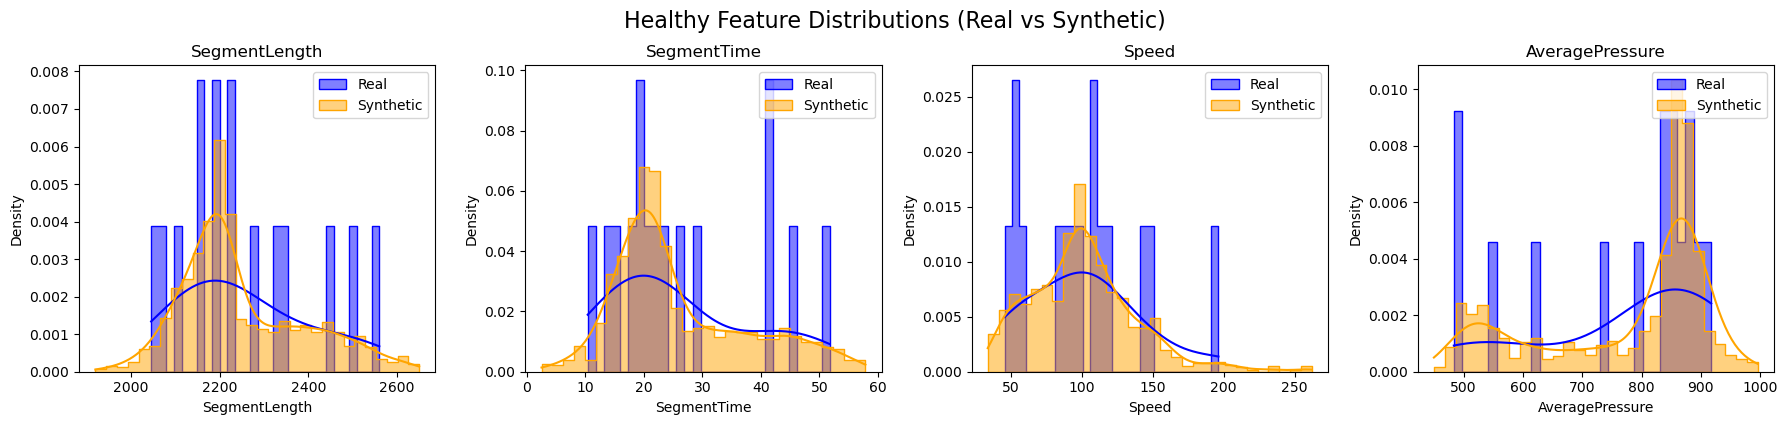

In [42]:
plot_all_features(real_df, synthetic_df, cls, save=True)


In [43]:
# Load real data
real_healthy = pd.read_csv("healthy_real_data20250511.csv").assign(Group="Healthy", Source="Real")
real_parkinson = pd.read_csv("parkinsonian_real_data20250511.csv").assign(Group="Parkinsonian", Source="Real")

# Load synthetic data
synthetic_healthy = pd.read_csv("healthy_synthetic_data20250511_optimized.csv").assign(Group="Healthy", Source="Synthetic")
synthetic_parkinson = pd.read_csv("parkinsonian_synthetic_data20250511_optimized.csv").assign(Group="Parkinsonian", Source="Synthetic")

# Combine into one DataFrame for each source
df_real = pd.concat([real_healthy, real_parkinson], ignore_index=True)
df_synthetic = pd.concat([synthetic_healthy, synthetic_parkinson], ignore_index=True)


In [44]:
# Load real data
real_healthy = pd.read_csv("healthy_real_data20250511.csv").assign(Group="Healthy", Source="Real")
real_parkinson = pd.read_csv("parkinsonian_real_data20250511.csv").assign(Group="Parkinsonian", Source="Real")

# Load synthetic data
synthetic_healthy = pd.read_csv("healthy_synthetic_data20250511_optimized.csv").assign(Group="Healthy", Source="Synthetic")
synthetic_parkinson = pd.read_csv("parkinsonian_synthetic_data20250511_optimized.csv").assign(Group="Parkinsonian", Source="Synthetic")

# Combine into one DataFrame for each source
df_real = pd.concat([real_healthy, real_parkinson], ignore_index=True)
df_synthetic = pd.concat([synthetic_healthy, synthetic_parkinson], ignore_index=True)


In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_boxplots_by_group(df, source_label):
    features = [col for col in df.columns if col not in ['Group', 'Source']]
    for feature in features:
        plt.figure(figsize=(6, 4))
        sns.boxplot(x='Group', y=feature, data=df)
        plt.title(f'{feature} by Group ({source_label})')
        plt.tight_layout()
        plt.savefig(f'boxplot_{feature}_{source_label}.png', dpi=300)
        plt.show()


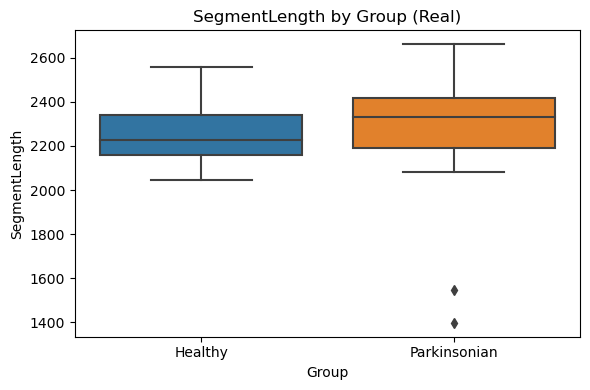

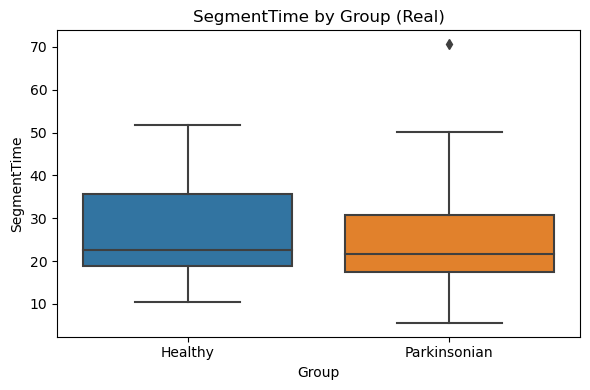

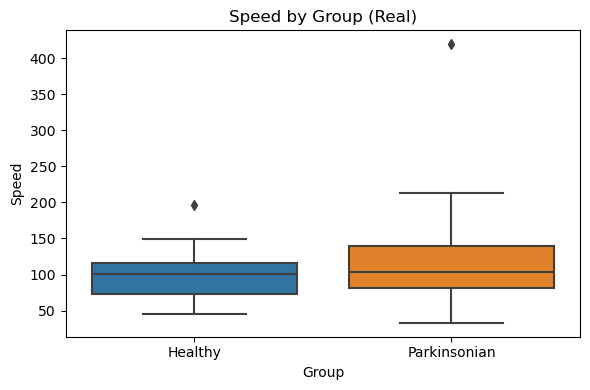

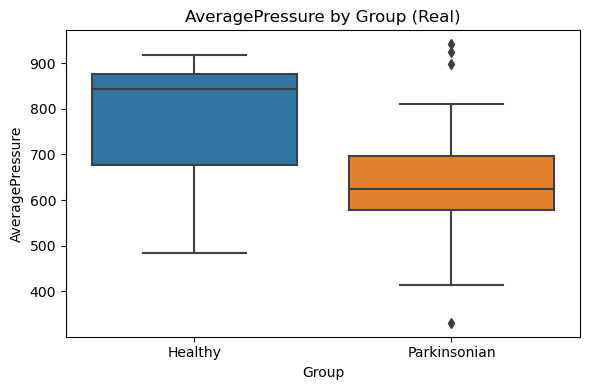

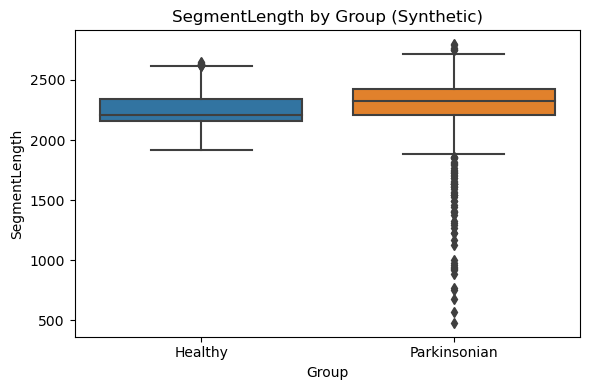

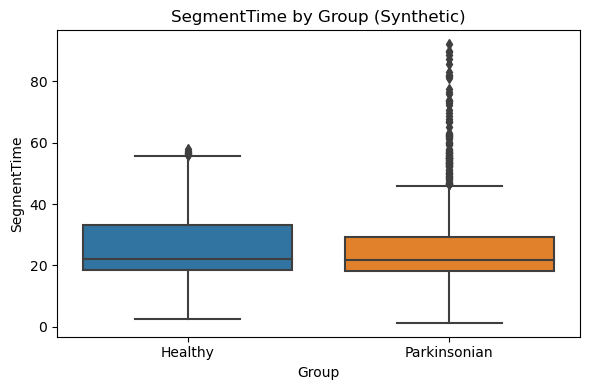

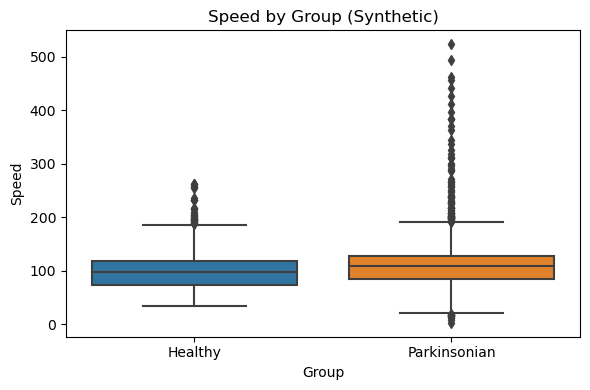

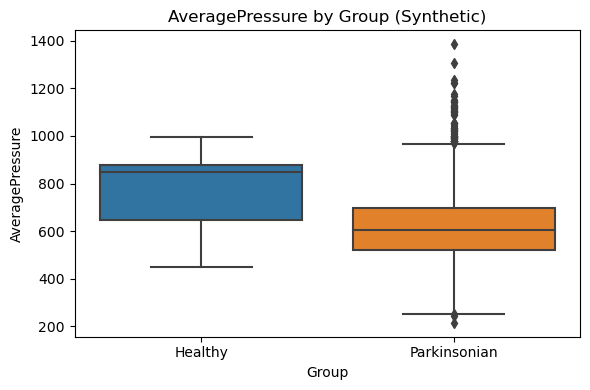

In [46]:
plot_boxplots_by_group(df_real, "Real")
plot_boxplots_by_group(df_synthetic, "Synthetic")


In [47]:
# Load real and synthetic datasets without labels
real_healthy = pd.read_csv("healthy_real_data20250511.csv").drop(columns=["Group"], errors='ignore')
real_parkinson = pd.read_csv("parkinsonian_real_data20250511.csv").drop(columns=["Group"], errors='ignore')
synthetic_healthy = pd.read_csv("healthy_synthetic_data20250511_optimized.csv")
synthetic_parkinson = pd.read_csv("parkinsonian_synthetic_data20250511_optimized.csv")

# Combine each
real_data = pd.concat([real_healthy, real_parkinson], ignore_index=True)
synthetic_data = pd.concat([synthetic_healthy, synthetic_parkinson], ignore_index=True)


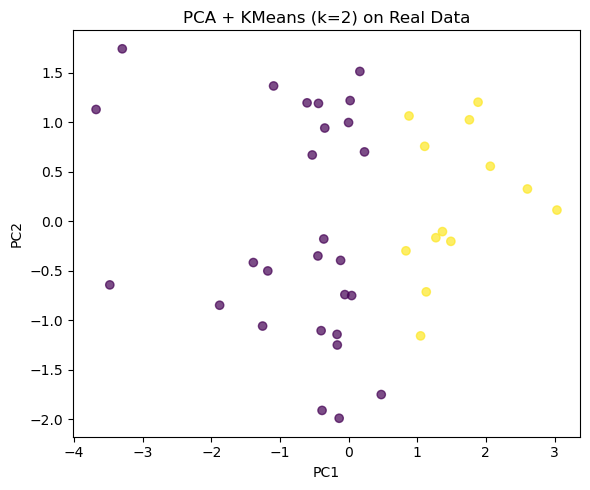

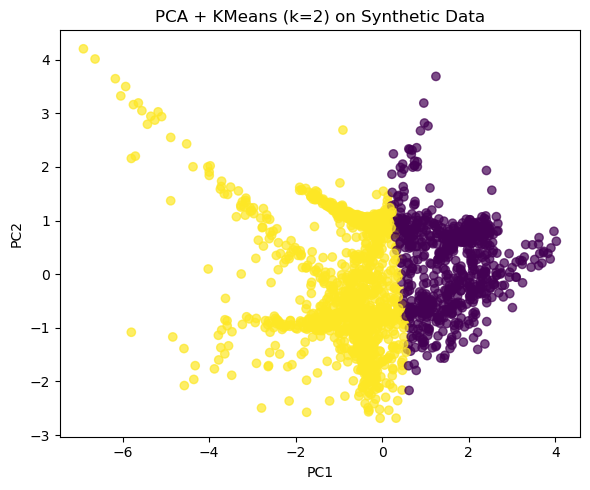

In [48]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def run_unsupervised_analysis(data, title=""):
    # Scale
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)

    # PCA
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(data_scaled)

    # KMeans (just to check structure)
    kmeans = KMeans(n_clusters=2, random_state=42)
    clusters = kmeans.fit_predict(data_scaled)

    # Plot
    plt.figure(figsize=(6, 5))
    plt.scatter(reduced[:, 0], reduced[:, 1], c=clusters, cmap='viridis', alpha=0.7)
    plt.title(f"PCA + KMeans (k=2) on {title}")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.tight_layout()
    plt.savefig(f"PCA_KMeans_{title}.png", dpi=300)
    plt.show()

# Run separately
run_unsupervised_analysis(real_data, "Real Data")
run_unsupervised_analysis(synthetic_data, "Synthetic Data")


In [49]:
# Assign dummy labels just for model testing SUpervised
real_data['Label'] = [0]*len(real_healthy) + [1]*len(real_parkinson)
synthetic_data['Label'] = [0]*len(synthetic_healthy) + [1]*len(synthetic_parkinson)

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

def run_classification(data, title=""):
    X = data.drop(columns=["Label"])
    y = data["Label"]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    print(f"📊 Classification on {title}:\n")
    print(classification_report(y_test, y_pred))

# Optional: test classification
run_classification(real_data, "Real Data")
run_classification(synthetic_data, "Synthetic Data")


📊 Classification on Real Data:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.67      0.67      0.67         6

    accuracy                           0.50         8
   macro avg       0.33      0.33      0.33         8
weighted avg       0.50      0.50      0.50         8

📊 Classification on Synthetic Data:

              precision    recall  f1-score   support

           0       0.94      0.95      0.94       199
           1       0.95      0.94      0.94       201

    accuracy                           0.94       400
   macro avg       0.94      0.94      0.94       400
weighted avg       0.94      0.94      0.94       400



In [50]:
!pip install shap



In [51]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import shap
import matplotlib.pyplot as plt

# =======================
# 📥 1. Load Data
# =======================

# Load real and synthetic, with labels
real_healthy = pd.read_csv("healthy_real_data20250511.csv").assign(Label=0)
real_parkinson = pd.read_csv("parkinsonian_real_data20250511.csv").assign(Label=1)

synthetic_healthy = pd.read_csv("healthy_synthetic_data20250511_optimized.csv").assign(Label=0)
synthetic_parkinson = pd.read_csv("parkinsonian_synthetic_data20250511_optimized.csv").assign(Label=1)

# Combine
real_df = pd.concat([real_healthy, real_parkinson], ignore_index=True)
synthetic_df = pd.concat([synthetic_healthy, synthetic_parkinson], ignore_index=True)

# Drop unnecessary columns
real_df = real_df.drop(columns=["Group"], errors="ignore")
feature_columns = ['SegmentLength', 'SegmentTime', 'Speed', 'AveragePressure']


In [52]:
# Scale using same scaler for both
scaler = StandardScaler()
X_synthetic = scaler.fit_transform(synthetic_df[feature_columns])
y_synthetic = synthetic_df['Label']

X_real = scaler.transform(real_df[feature_columns])
y_real = real_df['Label']


In [53]:
# Train on synthetic
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_synthetic, y_synthetic)

# Test on real
y_pred = model.predict(X_real)

print("📊 Classification Report (Trained on Synthetic → Tested on Real):\n")
print(classification_report(y_real, y_pred, digits=4))


📊 Classification Report (Trained on Synthetic → Tested on Real):

              precision    recall  f1-score   support

           0     0.8333    1.0000    0.9091        15
           1     1.0000    0.8800    0.9362        25

    accuracy                         0.9250        40
   macro avg     0.9167    0.9400    0.9226        40
weighted avg     0.9375    0.9250    0.9260        40



🔍 Feature Importances (from Random Forest):
           Feature  Importance
3  AveragePressure    0.425955
0    SegmentLength    0.288842
2            Speed    0.167286
1      SegmentTime    0.117917


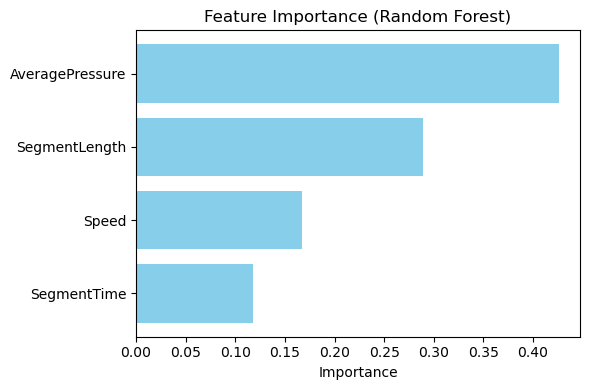

In [54]:
import pandas as pd
import matplotlib.pyplot as plt

# Get feature importance from the trained model
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display as a table
print("🔍 Feature Importances (from Random Forest):")
print(feature_importance_df)

# Plot
plt.figure(figsize=(6, 4))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel("Importance")
plt.title("Feature Importance (Random Forest)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("feature_importance_rf.png", dpi=300)
plt.show()


🔍 Feature Importances (Trained on Synthetic Data):
           Feature  Importance
3  AveragePressure    0.425955
0    SegmentLength    0.288842
2            Speed    0.167286
1      SegmentTime    0.117917


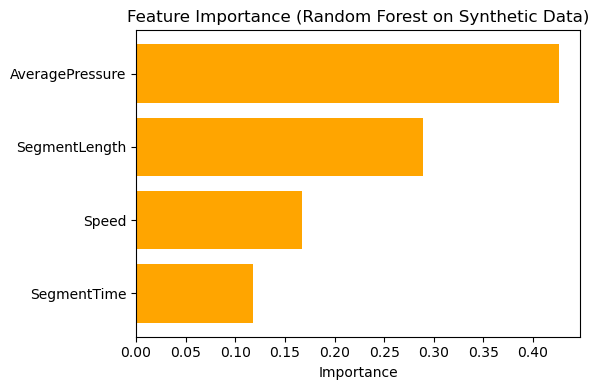

In [55]:
import pandas as pd
import matplotlib.pyplot as plt

# Re-train model on synthetic data (just to ensure we're referencing the right one)
model_synthetic = RandomForestClassifier(n_estimators=100, random_state=42)
model_synthetic.fit(X_synthetic, y_synthetic)

# Extract importances
importances = model_synthetic.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display in console
print("🔍 Feature Importances (Trained on Synthetic Data):")
print(feature_importance_df)

# Plot
plt.figure(figsize=(6, 4))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='orange')
plt.xlabel("Importance")
plt.title("Feature Importance (Random Forest on Synthetic Data)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("feature_importance_synthetic_rf.png", dpi=300)
plt.show()




🔍 Feature Importances (Trained on Real Data):
           Feature  Importance
3  AveragePressure    0.395448
0    SegmentLength    0.217474
2            Speed    0.196409
1      SegmentTime    0.190669


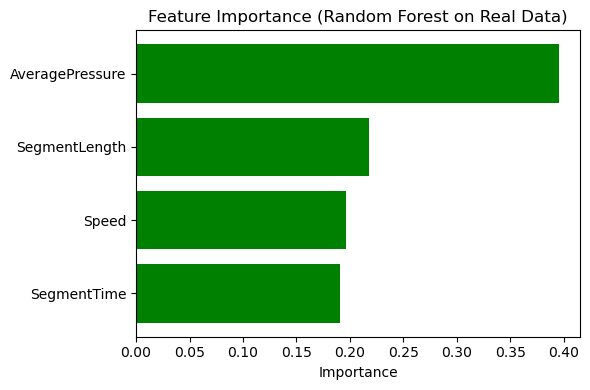

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

# Re-train model on real data only
model_real = RandomForestClassifier(n_estimators=100, random_state=42)

# Scale real data
scaler_real = StandardScaler()
X_real_scaled = scaler_real.fit_transform(real_df[feature_columns])
y_real = real_df["Label"]

# Fit the model
model_real.fit(X_real_scaled, y_real)

# Extract feature importances
importances = model_real.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display
print("🔍 Feature Importances (Trained on Real Data):")
print(feature_importance_df)

# Plot
plt.figure(figsize=(6, 4))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='green')
plt.xlabel("Importance")
plt.title("Feature Importance (Random Forest on Real Data)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("feature_importance_real_rf.png", dpi=300)
plt.show()


In [57]:
import pandas as pd

# Load CSV (already in correct orientation)
stats_park = pd.read_csv("parkinsonian_synthetic_statistics20250511_optimized.csv", index_col=0)
stats_healthy = pd.read_csv("healthy_synthetic_statistics20250511_optimized.csv", index_col=0)

# Strip row index names just in case there are hidden spaces
stats_park.index = stats_park.index.str.strip()
stats_healthy.index = stats_healthy.index.str.strip()

def extract_fuzzy_sets(stats_df):
    fuzzy_sets = {}

    for feature in stats_df.columns:
        min_val = stats_df.at['min', feature]
        q1 = stats_df.at['25%', feature]
        q2 = stats_df.at['50%', feature]
        q3 = stats_df.at['75%', feature]
        max_val = stats_df.at['max', feature]

        fuzzy_sets[feature] = {
            'Low':    (min_val, q1, q2),
            'Medium': (q1, q2, q3),
            'High':   (q2, q3, max_val)
        }

    return fuzzy_sets

# Extract fuzzy sets
fuzzy_park = extract_fuzzy_sets(stats_park)
fuzzy_healthy = extract_fuzzy_sets(stats_healthy)

# Print fuzzy sets
def print_fuzzy_sets(fuzzy_sets, label):
    print(f"\n🔹 Fuzzy sets for {label}:")
    for feature, sets in fuzzy_sets.items():
        print(f"\n{feature}")
        for name, (a, b, c) in sets.items():
            print(f"  {name}: ({a:.2f}, {b:.2f}, {c:.2f})")

print_fuzzy_sets(fuzzy_park, "Parkinsonian Synthetic")
print_fuzzy_sets(fuzzy_healthy, "Healthy Synthetic")



🔹 Fuzzy sets for Parkinsonian Synthetic:

SegmentLength
  Low: (479.79, 2206.56, 2323.37)
  Medium: (2206.56, 2323.37, 2422.11)
  High: (2323.37, 2422.11, 2796.98)

SegmentTime
  Low: (1.29, 18.02, 21.70)
  Medium: (18.02, 21.70, 29.37)
  High: (21.70, 29.37, 92.12)

Speed
  Low: (2.68, 84.39, 108.11)
  Medium: (84.39, 108.11, 127.48)
  High: (108.11, 127.48, 523.78)

AveragePressure
  Low: (215.47, 519.67, 603.57)
  Medium: (519.67, 603.57, 699.05)
  High: (603.57, 699.05, 1384.84)

🔹 Fuzzy sets for Healthy Synthetic:

SegmentLength
  Low: (1919.70, 2156.48, 2209.36)
  Medium: (2156.48, 2209.36, 2340.36)
  High: (2209.36, 2340.36, 2649.94)

SegmentTime
  Low: (2.53, 18.35, 22.14)
  Medium: (18.35, 22.14, 33.26)
  High: (22.14, 33.26, 57.85)

Speed
  Low: (33.44, 73.92, 98.21)
  Medium: (73.92, 98.21, 118.98)
  High: (98.21, 118.98, 262.02)

AveragePressure
  Low: (449.72, 645.77, 848.85)
  Medium: (645.77, 848.85, 875.97)
  High: (848.85, 875.97, 995.89)


In [59]:
import pandas as pd

# Use your fuzzy sets already extracted
# fuzzy_park = extract_fuzzy_sets(stats_park)
# fuzzy_healthy = extract_fuzzy_sets(stats_healthy)

def triangle_membership(x, a, b, c):
    if x <= a or x >= c:
        return 0
    elif a < x <= b:
        return (x - a) / (b - a)
    elif b < x < c:
        return (c - x) / (c - b)

# Equal weights across all fuzzy levels and features
default_weights = {'Low': 0.33, 'Medium': 0.33, 'High': 0.33}

def compute_fuzzy_score(sample, fuzzy_set):
    score = 0
    for feature in fuzzy_set:
        val = sample[feature]
        memberships = {
            level: triangle_membership(val, *fuzzy_set[feature][level])
            for level in ['Low', 'Medium', 'High']
        }
        score += sum(memberships[level] * default_weights[level] for level in memberships)
    return score / len(fuzzy_set)  # Normalize to [0,1]

# Load real data
real_healthy = pd.read_csv("healthy_real_data20250511.csv").assign(Group="Healthy")
real_park = pd.read_csv("parkinsonian_real_data20250511.csv").assign(Group="Parkinsonian")
real_df = pd.concat([real_healthy, real_park], ignore_index=True)

# Score each real row
results = []
for idx, row in real_df.iterrows():
    park_score = compute_fuzzy_score(row, fuzzy_park)
    healthy_score = compute_fuzzy_score(row, fuzzy_healthy)
    label = "Parkinsonian" if park_score > healthy_score else "Healthy"
    results.append({
        "ParkinsonianScore": round(park_score, 3),
        "HealthyScore": round(healthy_score, 3),
        "LikelyClass": label
    })

# Combine with original real data
score_df = pd.concat([real_df.reset_index(drop=True), pd.DataFrame(results)], axis=1)
print(score_df[["ParkinsonianScore", "HealthyScore", "LikelyClass", "Group"]])


    ParkinsonianScore  HealthyScore   LikelyClass         Group
0               0.307         0.324       Healthy       Healthy
1               0.319         0.330       Healthy       Healthy
2               0.282         0.271  Parkinsonian       Healthy
3               0.306         0.317       Healthy       Healthy
4               0.280         0.254  Parkinsonian       Healthy
5               0.312         0.330       Healthy       Healthy
6               0.306         0.324       Healthy       Healthy
7               0.284         0.251  Parkinsonian       Healthy
8               0.257         0.207  Parkinsonian       Healthy
9               0.255         0.232  Parkinsonian       Healthy
10              0.253         0.220  Parkinsonian       Healthy
11              0.312         0.330       Healthy       Healthy
12              0.271         0.164  Parkinsonian       Healthy
13              0.291         0.193  Parkinsonian       Healthy
14              0.318         0.261  Par

In [60]:
from sklearn.metrics import classification_report, f1_score

# Map to 0 and 1 for sklearn
y_true = score_df['Group'].map({'Healthy': 0, 'Parkinsonian': 1}).values
y_pred = score_df['LikelyClass'].map({'Healthy': 0, 'Parkinsonian': 1}).values

print("\n📊 Fuzzy-Based Classification Report on Real Data:")
print(classification_report(y_true, y_pred, digits=4))

# Optional: just the F1 score
f1 = f1_score(y_true, y_pred)
print(f"✅ F1 Score: {f1:.4f}")



📊 Fuzzy-Based Classification Report on Real Data:
              precision    recall  f1-score   support

           0     0.6667    0.4000    0.5000        15
           1     0.7097    0.8800    0.7857        25

    accuracy                         0.7000        40
   macro avg     0.6882    0.6400    0.6429        40
weighted avg     0.6935    0.7000    0.6786        40

✅ F1 Score: 0.7857


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# === 1. Load and merge synthetic datasets ===
synthetic_healthy = pd.read_csv("healthy_synthetic_data20250511_optimized.csv").assign(Label=0)
synthetic_parkinson = pd.read_csv("parkinsonian_synthetic_data20250511_optimized.csv").assign(Label=1)
df = pd.concat([synthetic_healthy, synthetic_parkinson], ignore_index=True)

# === 2. Select features to fuzzify ===
features_to_fuzzify = [
    "SegmentLength",
    "Speed",
    "AveragePressure"
]

# === 3. Function to compute tight triangular fuzzy sets ===
def tight_triangular_sets(values, feature):
    values = values.dropna()
    min_val = values.min()
    max_val = values.max()
    
    if min_val == max_val:
        return [{"Feature": feature, "FuzzySet": "All", "a": min_val, "b": min_val, "c": min_val}]
    
    p20 = np.percentile(values, 20)
    p35 = np.percentile(values, 35)
    p40 = np.percentile(values, 40)
    p50 = np.percentile(values, 50)
    p60 = np.percentile(values, 60)
    p65 = np.percentile(values, 65)
    p80 = np.percentile(values, 80)

    return [
        {"Feature": feature, "FuzzySet": "Low",    "a": min_val, "b": p20, "c": p40},
        {"Feature": feature, "FuzzySet": "Medium", "a": p35,     "b": p50, "c": p65},
        {"Feature": feature, "FuzzySet": "High",   "a": p60,     "b": p80, "c": max_val}
    ]

# === 4. Function to plot fuzzy sets ===
def plot_fuzzy_sets(fuzzy_defs, output_dir="fuzzy_plots"):
    os.makedirs(output_dir, exist_ok=True)
    features = set(fd["Feature"] for fd in fuzzy_defs)
    
    for feature in features:
        sets = [fd for fd in fuzzy_defs if fd["Feature"] == feature]
        xs = np.linspace(min(fd["a"] for fd in sets), max(fd["c"] for fd in sets), 500)
        
        plt.figure()
        for fd in sets:
            a, b, c = fd["a"], fd["b"], fd["c"]
            y = np.maximum(0, np.minimum((xs - a) / (b - a + 1e-9), (c - xs) / (c - b + 1e-9)))
            y[(xs <= a) | (xs >= c)] = 0
            y[xs == b] = 1
            plt.plot(xs, y, label=fd["FuzzySet"])
        
        plt.title(f"Fuzzy Sets for {feature}")
        plt.xlabel(feature)
        plt.ylabel("Membership Degree")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f"{output_dir}/{feature.replace(' ', '_')}_fuzzy_sets.png")
        plt.close()

# === 5. Generate fuzzy sets ===
fuzzy_definitions = []
for feature in features_to_fuzzify:
    if feature in df.columns:
        fuzzy_definitions.extend(tight_triangular_sets(df[feature], feature))
    else:
        print(f"⚠️ Feature not found in data: {feature}")

# === 6. Save to CSV ===
fuzzy_df = pd.DataFrame(fuzzy_definitions)
fuzzy_df.to_csv("tight_fuzzy_sets_from_synthetic.csv", index=False)
print("✅ Fuzzy sets saved to: tight_fuzzy_sets_from_synthetic.csv")

# === 7. Plot fuzzy sets ===
plot_fuzzy_sets(fuzzy_definitions)
print("📊 Fuzzy plots saved to: fuzzy_plots/")


✅ Fuzzy sets saved to: tight_fuzzy_sets_from_synthetic.csv
📊 Fuzzy plots saved to: fuzzy_plots/


In [9]:
import pandas as pd

# === 1. Load your data ===
df_healthy = pd.read_csv("healthy_real_data20250511.csv")
df_parkinsonian = pd.read_csv("parkinsonian_real_data20250511.csv")
fuzzy_sets = pd.read_csv("tight_fuzzy_sets_from_synthetic.csv")

# === 2. Combine both datasets ===
df = pd.concat([df_healthy, df_parkinsonian], ignore_index=True)

# === 3. Fuzzy membership function (triangular) ===
def triangular_membership(x, a, b, c):
    if x <= a or x >= c:
        return 0
    elif a < x <= b:
        return (x - a) / (b - a + 1e-9)
    elif b < x < c:
        return (c - x) / (c - b + 1e-9)
    return 0

# === 4. Apply fuzzy categorization ===
fuzzy_results = []

features = fuzzy_sets['Feature'].unique()

for _, row in df.iterrows():
    result = {'PatientID': row['PatientID'], 'Group': row['Group']}
    for feature in features:
        value = row[feature]
        # Get fuzzy sets for this feature
        sets = fuzzy_sets[fuzzy_sets['Feature'] == feature]
        memberships = {}
        for _, fuzzy in sets.iterrows():
            label = fuzzy['FuzzySet']
            a, b, c = fuzzy['a'], fuzzy['b'], fuzzy['c']
            memberships[label] = triangular_membership(value, a, b, c)
        # Assign the label with highest membership
        best_label = max(memberships, key=memberships.get)
        result[f"{feature}_Category"] = best_label
    fuzzy_results.append(result)

# === 5. Save fuzzy labels per patient ===
fuzzy_df = pd.DataFrame(fuzzy_results)
fuzzy_df.to_csv("fuzzy_categorized_patients20250511.csv", index=False)

print("✅ Fuzzy categories assigned and saved to: fuzzy_categorized_patients20250511.csv")


✅ Fuzzy categories assigned and saved to: fuzzy_categorized_patients20250511.csv


In [10]:
import pandas as pd

# === 1. Load the fuzzy categorized data ===
fuzzy_df = pd.read_csv("fuzzy_categorized_patients20250511.csv")

# === 2. Create a string-based rule signature for each patient ===
fuzzy_df['Rule'] = (
    "SegmentLength=" + fuzzy_df['SegmentLength_Category'] + " | " +
    "Speed=" + fuzzy_df['Speed_Category'] + " | " +
    "AveragePressure=" + fuzzy_df['AveragePressure_Category']
)

# === 3. Count rule occurrences by Group ===
rule_counts = fuzzy_df.groupby(['Group', 'Rule']).size().reset_index(name='Count')

# === 4. Pivot for easier comparison (optional) ===
pivot = rule_counts.pivot(index='Rule', columns='Group', values='Count').fillna(0).astype(int)
pivot = pivot.sort_values(by=pivot.columns.tolist(), ascending=False)

# === 5. Save results ===
pivot.to_csv("fuzzy_rule_counts_by_group20250511.csv")
print("✅ Saved fuzzy rule occurrence counts to: fuzzy_rule_counts_by_group20250511.csv")

# Optional: print top rules
print("\n📊 Top fuzzy rules by group:")
print(pivot.head(10))


✅ Saved fuzzy rule occurrence counts to: fuzzy_rule_counts_by_group20250511.csv

📊 Top fuzzy rules by group:
Group                                               Healthy  Parkinsonian
Rule                                                                     
SegmentLength=High | Speed=Low | AveragePressur...        3             0
SegmentLength=High | Speed=Low | AveragePressur...        2             5
SegmentLength=Low | Speed=High | AveragePressur...        2             2
SegmentLength=Low | Speed=High | AveragePressur...        2             1
SegmentLength=Medium | Speed=Medium | AveragePr...        2             1
SegmentLength=Low | Speed=Medium | AveragePress...        2             0
SegmentLength=Low | Speed=Medium | AveragePress...        1             4
SegmentLength=Medium | Speed=Low | AveragePress...        1             0
SegmentLength=High | Speed=High | AveragePressu...        0             3
SegmentLength=High | Speed=Low | AveragePressur...        0             2
